# Benchmarks
In this notebook we will try to identify the potential bottlenecks of the synchronization system, and show a series of benchmarks with different RDF datasets.

## Setup

As always, we will begin by adding the hercules_sync library to our path, and setting up the logging system.

In [1]:
import logging
import os
import sys

# set up module paths for imports
module_path = os.path.abspath(os.path.join('..'))
hercules_sync_path = os.path.abspath(os.path.join('..', 'hercules_sync'))
sys.path.append(module_path)
sys.path.append(hercules_sync_path)

# start logging system and set logging level
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.info("Starting logger")

output_images_path = "img"

%load_ext snakeviz

In [2]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')

%matplotlib inline

## Datasets used

In order to execute our benchmarks we are going to use two different datasets:
* Real dataset: A DBpedia dataset with information about different people is going to be used to represent the performance of our system with a real dataset.
* Synthetic dataset: We are also going to use the Berlin SPARQL Benchmark tool to generate datasets of different sizes and observe the performance of our system as the size of the data to be synchronized increases.

We will begin by defining a set of functions that can be used to download the dbpedia dataset and obtain a subset of it:

In [3]:
import bz2
import urllib.request

def read_zipped_dataset(url, decompressor=bz2):
    response = urllib.request.urlopen(url)
    content = bz2.decompress(response.read())
    return content

def get_first_lines(string, num_lines):
    return b'\n'.join(string.split(b'\n')[:num_lines])


Now, we will use the functions defined above to load the person data from DBpedia. Three different datasets will be stored:
* dbpedia_dataset will contain the complete dataset
* dbpedia_dataset_preview will contain just the first 100 lines of the dataset. This subset will be used first to identify potential bottlenecks of the system.
* dbpedia_dataset_final will contain the first 4000 lines of the dataset. This subset will be used later on for our benchmarks will real data.

In [4]:
DBPEDIA_PERSONDATA_URL = 'http://downloads.dbpedia.org/3.4/en/persondata_en.nt.bz2'
NUM_TRIPLES_FINAL = 5000
NUM_TRIPLES_PREVIEW = 100

dbpedia_dataset = read_zipped_dataset(DBPEDIA_PERSONDATA_URL, bz2)
dbpedia_dataset_preview = get_first_lines(dbpedia_dataset, NUM_TRIPLES_PREVIEW)
dbpedia_dataset_final = get_first_lines(dbpedia_dataset, NUM_TRIPLES_FINAL)

Now, we will proceed to create the synthetic datasets. We will first create a function that calls the BSBM tool to generate a synthetic dataset with the given number of products:

In [5]:
import subprocess

OUTPUT_FILE_NAME = "dataset.nt"

def gen_synthetic_data(num_products=100, bsbmtools_dir="bsbmtools-0.2"):
    subprocess.call(f"cd {bsbmtools_dir} && ./generate -fc -pc {num_products}", shell=True)
    with open(os.path.join(bsbmtools_dir, OUTPUT_FILE_NAME), 'r') as f:
        res = f.read()
    return res


Now we will call the function multiple times to produce files of different sizes to evaluate our system.

In [6]:
data = [gen_synthetic_data(i) for i in range(1, 47, 5)]

Finally, we will convert the previous list to a dict where the keys are the number of triples in the file, and the value is the file itself. This will be useful later on to plot the results of our benchmarks.

In [7]:
from rdflib.graph import Graph

def count_triples(string):
    graph = Graph().parse(format='n3', data=string)
    return len(graph)

synthetic_data_final = {count_triples(string): string for string in data}
synthetic_data_final.keys()

dict_keys([1844, 3590, 5350, 7086, 8859, 10601, 12380, 15585, 17327, 19065])

## Analysing bottlenecks of the application

In this section we are going to execute an initial dump of the DBpedia preview dataset to identify which are the parts of the synchronization that take the most amount of time to execute. First of all, we are going to define the algorithm to use, and to reset the URIs factory to an initial state:

In [8]:
from wbsync.external.uri_factory import URIFactoryMock
from wbsync.synchronization import GraphDiffSyncAlgorithm, OntologySynchronizer

algorithm = GraphDiffSyncAlgorithm()
synchronizer = OntologySynchronizer(algorithm)
factory = URIFactoryMock()
factory.reset_factory()

/home/alejandro/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Now, we will define a function to completely reset the state of the Wikibase instance. Since we are going to make several dumps of data to the Wikibase in this notebook, it is important to reset its state before adding more data. In this case we are connecting to the machine where the Wikibase is running (in docker containers), and calling a script that resets the docker volumes:

In [9]:
import time

from wbsync.triplestore import WikibaseAdapter
from secret import SSH_USER, SSH_PASS, USERNAME, PASSWORD

wikibase_host = '156.35.94.149'
ssh_port = '22'
mediawiki_api_url = f'http://{wikibase_host}:8181/w/api.php'
sparql_endpoint_url = f'http://{wikibase_host}:8282/proxy/wdqs/bigdata/namespace/wdq/sparql'
adapter = None

def reset_wb_state(factory):
    global adapter
    print("Resetting Wikibase state...")
    subprocess.call('cd ~/wikibase-docker && sh clean_restart.sh', shell=True)
    print("Wikibase state has been reset")
    factory.reset_factory()
    time.sleep(15) # wait some time for docker containers to go up again
    print("Logging to wikibase...")
    adapter = WikibaseAdapter(mediawiki_api_url, sparql_endpoint_url, USERNAME, PASSWORD)


Now we will define the function to be benchmarked. This function executes the synchronization of the given data to Wikibase:

In [10]:
def execute_synchronization(source_content, target_content, synchronizer, adapter):
    ops = synchronizer.synchronize(source_content, target_content)
    for op in ops:
        res = op.execute(adapter)
        if not res.successful:
            print(f"Error synchronizing triple: {res.message}")

Finally, we will run the function and obtain some visualizations about its performance using the snakeviz tool:

In [11]:
reset_wb_state(factory)
%snakeviz execute_synchronization("", dbpedia_dataset_preview, synchronizer, adapter)

Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin


/home/alejandro/.local/lib/python3.7/site-packages/wikidataintegrator/wdi_core.py:218: UserWarning: Warning: No distinct value properties found
Please set P2302 and Q21502410 in your wikibase or set `core_props` manually.
Continuing with no core_props
  "Please set P2302 and Q21502410 in your wikibase or set `core_props` manually.\n" +
/home/alejandro/.local/lib/python3.7/site-packages/wikidataintegrator/wdi_core.py:175: UserWarning: mapping relation types are being ignored
  warnings.warn("mapping relation types are being ignored")


 
*** Profile stats marshalled to file '/tmp/tmp5tiefalx'. 
Embedding SnakeViz in this document...


As we can see above, more than half of the time regarding synchronization is spent in the write method of wdi_core. In the following sections we will try to propose some solutions to alleviate this issue.

## Batch vs Basic operations

As have seen in the previous section, the writing of triples to Wikibase is the main bottleneck of the system. In order to alleviate this problem, the 'optimize_ops' function is provided to convert a list of BasicOperations into BatchOperations.

With this optimization the system will try to perform less writting operations, using instead the 'update' methods provided by WikidataIntegrator. In this section we are going to compare the performance using the basic operations against the 'optimized' version. First of all, we are going to define the functions needed to execute both types of synchronization:

In [12]:
from wbsync.synchronization.operations import optimize_ops

def _synchronize(source_content, target_content, synchronizer, adapter, ops_callback):
    ops = ops_callback(source_content, target_content)
    for op in ops:
        res = op.execute(adapter)
        if not res.successful:
            print(f"Error synchronizing triple: {res.message}")

def execute_basic_synchronization(source_content, target_content, synchronizer, adapter):
    ops_callback = lambda f: synchronizer.synchronize(f)
    return _synchronize(source_content, target_content, synchronizer, adapter, ops_callback)
    
def execute_batch_synchronization(source_content, target_content, synchronizer, adapter):
    ops_callback = lambda f: optimize_ops(synchronizer.synchronize(f))
    return _synchronize(source_content, target_content, synchronizer, adapter, ops_callback)


The first auxiliary function, '\_synchronize', is very similar to the synchronization function defined previously to profile the preview dataset. However, in this case we are receiving an additional callback to obtain the list of operations from the file.

After that we define two more functions. The first one corresponds to the basic approach used so far, where the operations are obtained directly from our OntologySynchronizer instance. The second function will additionally call the _optimize\_ops_ function on the operations to optimize them.

We will now declare a basic function to execute the synchronization on the synthetic dataset and time it:

In [13]:
import timeit

from functools import partial


def time_synth_dataset(callback, setup, dataset_dict):
    results = {}
    for num_triples, data in dataset_dict.items():
        setup()
        print(f"Execute callback: {num_triples} number of triples")
        elapsed_time = timeit.timeit(partial(callback, data), number=1)
        print(f"Callback finished in {elapsed_time} seconds")
        results[num_triples] = elapsed_time
    return results


With the function defined, we will measure both the times to synchronize the data with batch and base operations:

In [14]:
reset_state_callback = partial(reset_wb_state, factory=factory)

results_batch = time_synth_dataset(lambda f: execute_batch_synchronization("", f, synchronizer, adapter),
                                  reset_state_callback, synthetic_data_final)
results_base = time_synth_dataset(lambda f: execute_basic_synchronization("", f, synchronizer, adapter),
                                  reset_state_callback, synthetic_data_final)

Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin
Execute callback: 1844 number of triples
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Callback finished in 1672.3779016891494 seconds
Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin
Execute callback: 12380 number of triples
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchron

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Callback finished in 3008.232153646648 seconds
Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin
Execute callback: 1844 number of triples
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchroniz

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Callback finished in 8066.93191533722 seconds
Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin
Execute callback: 12380 number of triples
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchroniz

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 characters long
Error while writing to Wikidata
Error synchronizing triple: Must be no more than 400 charac

Callback finished in 14492.734546638094 seconds


In [15]:
print("Synthetic dataset")
print("-" * 25)
print("Batch times: ", results_batch)
print("Base times: ", results_base)

Synthetic dataset
-------------------------
Batch times:  {1844: 459.4377486668527, 3590: 708.7538920678198, 5350: 947.8274464011192, 7086: 1191.1007397295907, 8859: 1432.0598395848647, 10601: 1672.3779016891494, 12380: 1919.307526204735, 15585: 2529.605444408022, 17327: 2773.9869729196653, 19065: 3008.232153646648}
Base times:  {1844: 1461.5747933993116, 3590: 2818.411590145901, 5350: 4111.614511852153, 7086: 5412.297922690399, 8859: 6745.113914155401, 10601: 8066.93191533722, 12380: 9397.42075445503, 15585: 11880.597315469757, 17327: 13162.404621123336, 19065: 14492.734546638094}


We can see how the batch updates perform considerably better. On average, executing the synchronization with batch is 3 times faster than using the basic approach.

Finally, we will plot the results that we have obtained to illustrate this better:

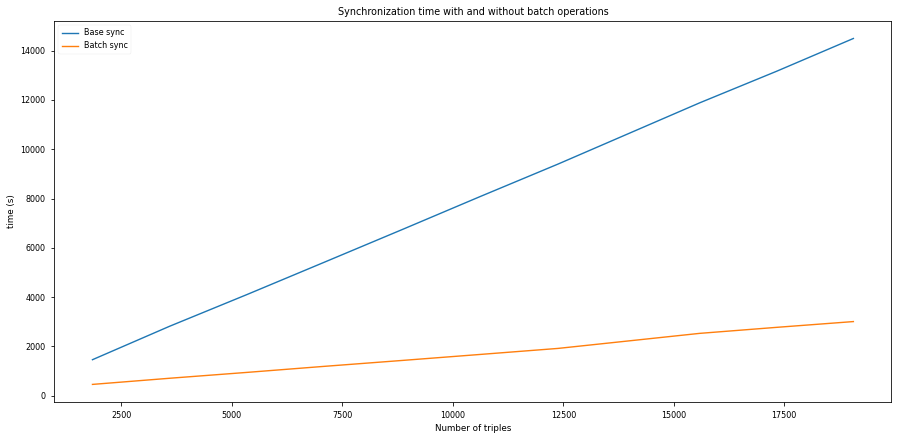

In [16]:
# line chart
def plot_synth_results(results_dict_base, results_dict_batch):
    x1, y1 = results_dict_base.keys(), results_dict_base.values()
    x2, y2 = results_dict_batch.keys(), results_dict_batch.values()
    plt.figure(figsize=(15, 7))
    plt.xlabel("Number of triples")
    plt.ylabel("time (s)")
    plt.title("Synchronization time with and without batch operations")
    plt.plot(list(x1), list(y1), label="Base sync")
    plt.plot(list(x2), list(y2), label="Batch sync")
    plt.legend(loc="upper left")
    plt.savefig(os.path.join(output_images_path, "linechart.png"), dpi=300, transparent=True)
    plt.show()

plot_synth_results(results_base, results_batch)

Now we will see what are the results obtained with the real DBpedia dataset:

In [17]:
reset_wb_state(factory)
results_dbpedia_base = timeit.timeit(partial(execute_basic_synchronization, "", dbpedia_dataset_final, synchronizer, adapter), number=1)

reset_wb_state(factory)
results_dbpedia_batch = timeit.timeit(partial(execute_batch_synchronization, "", dbpedia_dataset_final, synchronizer, adapter), number=1)

Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin
Resetting Wikibase state...
Wikibase state has been reset
Logging to wikibase...
http://156.35.94.149:8181/w/api.php
Successfully logged in as WikibaseAdmin


In [18]:
print("Real dataset (DBpedia)")
print("-" * 35)
print(f"Batch times: {results_dbpedia_batch}s")
print(f"Base times: {results_dbpedia_base}s")

Real dataset (DBpedia)
-----------------------------------
Batch times: 1595.2858651746064s
Base times: 4081.7650151364505s


We can see that the results are comparable to the ones obtained with the synthetic dataset. In this case, the batch synchronization is around 2.5 times faster than the base one.

To conclude this notebook, we will plot the results in a bar chart to illustrate this difference in performance:

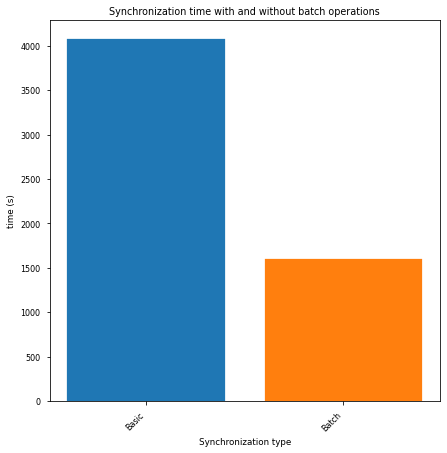

In [19]:
# bar chart
def plot_dbpedia_results(time_base, time_batch):
    x = ['Basic', 'Batch']
    y = [time_base, time_batch]
    
    x_pos = [i for i, _ in enumerate(x)]
    
    plt.figure(figsize=(7, 7))
    barlist = plt.bar(x_pos, y, width=0.8)
    barlist[0].set_color('C0')
    barlist[1].set_color('C1')
    plt.xlabel("Synchronization type")
    plt.ylabel("time (s)")
    plt.title("Synchronization time with and without batch operations")
    plt.xticks(x_pos, x)
    plt.ylim = 1.0
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.savefig(os.path.join(output_images_path, "barchart.png"), dpi=300, transparent=True)
    plt.show()

plot_dbpedia_results(results_dbpedia_base, results_dbpedia_batch)